In [9]:
# Parte 1: Cuerpo de la simulación, definición de parámetros más importantes y funciones
import numpy as np
from scipy.ndimage import grey_dilation
from tqdm.auto import tqdm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Parámetros de gran importáncia
TAMANO = 120.0       # Tamaño de la imagen en nm
RESOLUCION = 128     # Píxeles de la imagen
RADIO_PUNTA = 10.0   # Radio del extremo de la punta en nm
ANGULO_PUNTA = 40.0  # Ángulo del cono de la punta en gradosº

# Parámetros físicos para la fuerza de Lennard-Jones
EPSILON = 2e-20  # En Joules
SIGMA = 0.3      # nm

# Funciones que usaremos

def lennard_jones_force(d_nm):
    """
    Calcula la fuerza de Lennard-Jones con la fórmula matemáticamente exacta,
    derivada del potencial.
    """
    # Parámetros físicos
    EPSILON = 2e-20  # Joules
    SIGMA = 0.3      # nm
    # Conversión a metros para consistencia
    sigma_m = SIGMA * 1e-9
    d_m = d_nm * 1e-9
    # Evitar valores muy pequeños para la estabilidad numérica
    d_safe_m = np.maximum(d_m, sigma_m * 0.85)
    # Cálculo de los términos con las potencias correctas (13 y 7)
    r7 = (sigma_m / d_safe_m)**7
    r13 = (sigma_m / d_safe_m)**13
    # Fuerza en Newtons, usando la fórmula correcta
    force_N = (24 * EPSILON / sigma_m) * (2 * r13 - r7)
    # Conversión final a nanoNewtons
    return force_N * 1e9


def crear_superficie_muestra(tamano, resolucion):
    """Crea una superficie de prueba con algunas características."""
    x = np.linspace(-tamano/2, tamano/2, resolucion)
    y = np.linspace(-tamano/2, tamano/2, resolucion)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Estructuras creadas sobre un plano Z=0
    Z[(X > -40) & (X < 40) & (Y > -40) & (Y < 40)] = 1.5
    Z[(X > 10) & (X < 15) & (Y > -30) & (Y < 30)] = -2.0
    Z[(X + 30)**2 + (Y + 30)**2 < 8**2] = 2.0
    return X, Y, Z


def crear_forma_punta(radio, angulo, tamano, resolucion, pixels=65):
    """Crea la geometría 3D de la punta."""
    nm_por_pixel = tamano / resolucion
    centro = pixels // 2

    # Creación de la malla de coordenadas para la punta
    x_px = np.arange(-centro, centro + 1)
    y_px = np.arange(-centro, centro + 1)
    X_px, Y_px = np.meshgrid(x_px, y_px)
    R_nm = np.sqrt(X_px**2 + Y_px**2) * nm_por_pixel

    # Parte esférica del extremo
    parte_esferica = np.full(R_nm.shape, -np.inf)
    mascara = R_nm < radio
    parte_esferica[mascara] = np.sqrt(radio**2 - R_nm[mascara]**2) - radio

    # Parte cónica
    parte_conica = R_nm * -np.tan(np.radians(90 - angulo / 2))

    # Combinación de las dos formas
    forma_punta = np.maximum(parte_esferica, parte_conica)
    # Normalización (el punto más alto de la punta es Z=0)
    forma_punta -= np.max(forma_punta)
    return forma_punta


# Se ejecuta la simulación

print("Primero se genera la superfície y punta")
X, Y, Z_real = crear_superficie_muestra(TAMANO, RESOLUCION)
punta = crear_forma_punta(RADIO_PUNTA, ANGULO_PUNTA, TAMANO, RESOLUCION)

# Cálculo de la convolución
print("Segundo se calcula el efecto de la punta")
Z_convolucionada = grey_dilation(Z_real, structure=np.flip(punta))

# Cálculo del mapa de fuerzas
print("Tercero hacemos el AFM en modo altura constante")
altura_escaneo = np.max(Z_convolucionada) + 1.2
mapa_fuerzas = np.zeros_like(Z_convolucionada)

for y in tqdm(range(RESOLUCION), desc="Escaneando"):
    for x in range(RESOLUCION):
        distancia = altura_escaneo - Z_convolucionada[y, x]
        mapa_fuerzas[y, x] = lennard_jones_force(distancia)

print("\n Completado, puedes generar las imágenes.")

Primero se genera la superfície y punta
Segundo se calcula el efecto de la punta
Tercero hacemos el AFM en modo altura constante


Escaneando:   0%|          | 0/128 [00:00<?, ?it/s]


 Completado, puedes generar las imágenes.


Generando gráficos 2D...


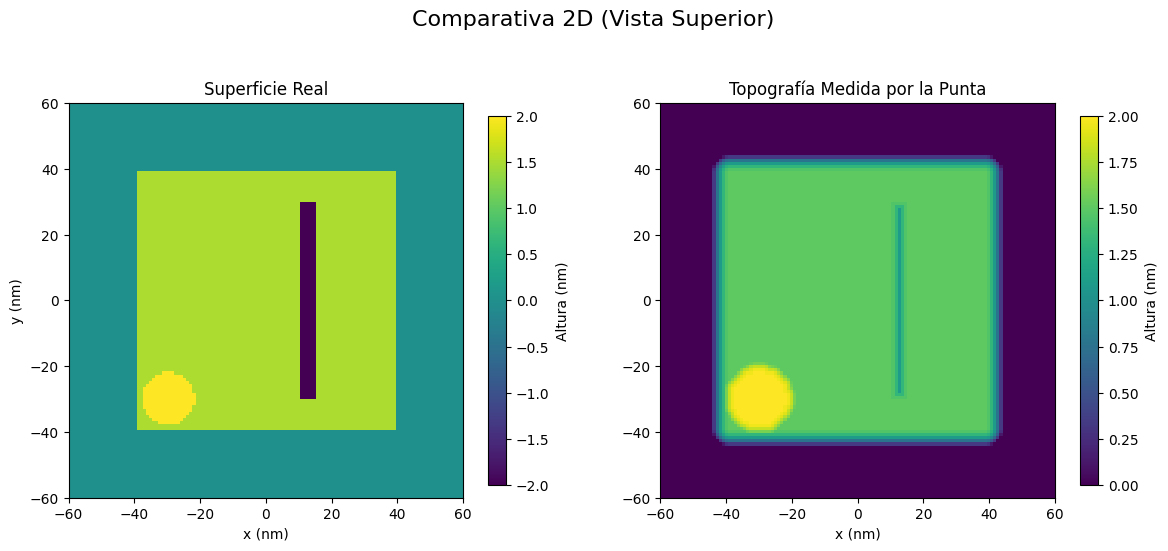

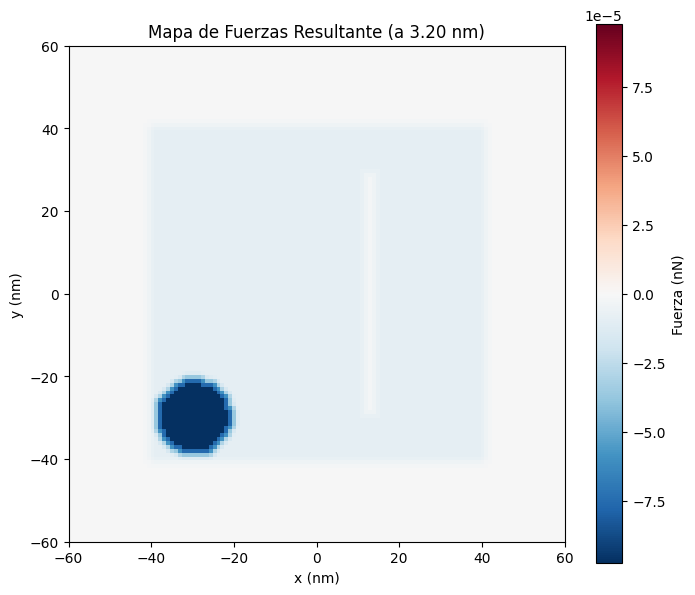


✅ Gráficos 2D generados.


In [16]:
# Celda 2: Gráficos 2D
print("Generando gráficos 2D...")

# Comparativa de la superficie real vs. la medida
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparativa 2D (Vista Superior)', fontsize=16)

im1 = ax1.imshow(Z_real, cmap='viridis', extent=[-TAMANO/2, TAMANO/2, -TAMANO/2, TAMANO/2], origin='lower')
ax1.set_title('Superficie Real')
ax1.set_xlabel('x (nm)')
ax1.set_ylabel('y (nm)')
fig.colorbar(im1, ax=ax1, label='Altura (nm)', shrink=0.8)

im2 = ax2.imshow(Z_convolucionada, cmap='viridis', extent=[-TAMANO/2, TAMANO/2, -TAMANO/2, TAMANO/2], origin='lower')
ax2.set_title('Topografía Medida por la Punta')
ax2.set_xlabel('x (nm)')
fig.colorbar(im2, ax=ax2, label='Altura (nm)', shrink=0.8)
plt.show()


# Mapa de fuerzas
plt.figure(figsize=(8, 7))
lim = np.percentile(np.abs(mapa_fuerzas), 99.8)
plt.imshow(mapa_fuerzas, cmap='RdBu_r', vmin=-lim, vmax=lim, extent=[-TAMANO/2, TAMANO/2, -TAMANO/2, TAMANO/2], origin='lower')
plt.title(f'Mapa de Fuerzas Resultante (a {altura_escaneo:.2f} nm)')
plt.colorbar(label='Fuerza (nN)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

print("\n✅ Gráficos 2D generados.")

In [11]:
# Celda 3: Gráficos 3D Interactivos
print("Generando gráficos 3D interactivos...")

# Gráfico de la Superficie Real
fig_real = go.Figure(data=[go.Surface(z=Z_real, x=X, y=Y, colorscale='Viridis')])
fig_real.update_layout(
    title='Superficie Real 3D',
    scene=dict(xaxis_title='X (nm)', yaxis_title='Y (nm)', zaxis_title='Altura (nm)'),
    width=800, height=700
)
fig_real.show()


# Gráfico de la Superficie Medida
fig_convolved = go.Figure(data=[go.Surface(z=Z_convolucionada, x=X, y=Y, colorscale='Cividis')])
fig_convolved.update_layout(
    title='Imagen 3D Medida por la Punta',
    scene=dict(xaxis_title='X (nm)', yaxis_title='Y (nm)', zaxis_title='Altura (nm)'),
    width=800, height=700
)
fig_convolved.show()


# Gráfico de la Punta
px_punta = punta.shape[0]
x_punta, y_punta = np.meshgrid(np.arange(px_punta), np.arange(px_punta))
fig_punta = go.Figure(data=[go.Surface(z=punta, x=x_punta, y=y_punta, colorscale='Greys', reversescale=True)])
fig_punta.update_layout(
    title=f'Forma de la Punta en 3D',
    scene=dict(
        xaxis_title='X (píxeles)', yaxis_title='Y (píxeles)', zaxis_title='Altura Relativa (nm)',
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    width=700, height=600
)
fig_punta.update_layout(scene_zaxis_autorange="reversed")
fig_punta.show()

print("\n✅ Fin del proceso.")

Generando gráficos 3D interactivos...



✅ Fin del proceso.
